## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller as af
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

## Data

In [2]:
sales_train = pd.read_csv('../Data/sales_train.csv')
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
item_categories_russian = pd.read_csv('../Data/item_categories.csv')
item_categories_russian

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [4]:
items_russian = pd.read_csv('../Data/items.csv')
items_russian

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [5]:
shops_russian = pd.read_csv('../Data/shops.csv')
shops_russian.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
sub_set = pd.read_csv('../Data/test.csv')
sub_set

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


You need to forecast the sales for these shops and products for November 2015.

In [7]:
sub_format = pd.read_csv('../Data/sample_submission.csv')

In [8]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


## Cleaning

In [9]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [10]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [11]:
sales_train['item_cnt_day'].value_counts().sort_index()

-22.0      1
-16.0      1
-9.0       1
-6.0       2
-5.0       4
          ..
 624.0     1
 637.0     1
 669.0     1
 1000.0    1
 2169.0    1
Name: item_cnt_day, Length: 198, dtype: int64

Outliers may need to be dealt with.

In [12]:
sales_train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [13]:
sales_train.date = pd.to_datetime(sales_train.date)
sales_train.set_index('date', inplace = True)

In [14]:
sales_train

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-02-01,0,59,22154,999.00,1.0
2013-03-01,0,25,2552,899.00,1.0
2013-05-01,0,25,2552,899.00,-1.0
2013-06-01,0,25,2554,1709.05,1.0
2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...
2015-10-10,33,25,7409,299.00,1.0
2015-09-10,33,25,7460,299.00,1.0
2015-10-14,33,25,7459,349.00,1.0


In [29]:
sales_monthly_avg = sales_train.item_cnt_day.resample('M').mean()
sales_monthly_avg

date
2013-01-31    1.155952
2013-02-28    1.197668
2013-03-31    1.217764
2013-04-30    1.176424
2013-05-31    1.246816
2013-06-30    1.263784
2013-07-31    1.183755
2013-08-31    1.205581
2013-09-30    1.337507
2013-10-31    1.249366
2013-11-30    1.281942
2013-12-31    1.275989
2014-01-31    1.182894
2014-02-28    1.235513
2014-03-31    1.270739
2014-04-30    1.291429
2014-05-31    1.297455
2014-06-30    1.196194
2014-07-31    1.185745
2014-08-31    1.198934
2014-09-30    1.311475
2014-10-31    1.198290
2014-11-30    1.350551
2014-12-31    1.279273
2015-01-31    1.216340
2015-02-28    1.201796
2015-03-31    1.205903
2015-04-30    1.414705
2015-05-31    1.328922
2015-06-30    1.184313
2015-07-31    1.159504
2015-08-31    1.180429
2015-09-30    1.404982
2015-10-31    1.278765
2015-11-30    1.200577
2015-12-31    1.177076
Freq: M, Name: item_cnt_day, dtype: float64

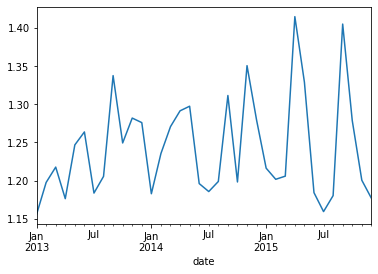

In [16]:
sales_monthly_avg.plot();

In [17]:
sales_monthly_avg.describe()

count    36.000000
mean      1.242899
std       0.066977
min       1.155952
25%       1.193582
50%       1.217052
75%       1.279940
max       1.414705
Name: item_cnt_day, dtype: float64

In [27]:
sales_monthly_sum = sales_train.item_cnt_day.resample('M').sum()

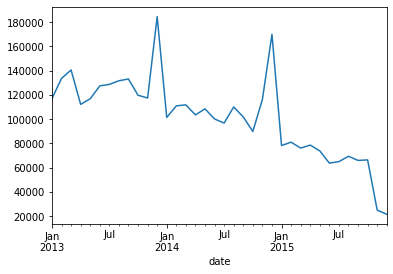

In [28]:
sales_monthly_sum.plot();

In [25]:
monthly_sales = pd.pivot_table(sales_train, index=['shop_id', 'item_id'],\
               columns=['date_block_num'], values=['item_cnt_day'],\
               aggfunc=np.mean, fill_value = 0).reset_index()
monthly_sales

shop_id item_id item_cnt_day                                \
date_block_num                            0         1    2    3    4    5   
0                    0      30          0.0  3.444444  0.0  0.0  0.0  0.0   
1                    0      31          0.0  1.571429  0.0  0.0  0.0  0.0   
2                    0      32          1.5  1.428571  0.0  0.0  0.0  0.0   
3                    0      33          1.0  1.000000  0.0  0.0  0.0  0.0   
4                    0      35          1.0  1.272727  0.0  0.0  0.0  0.0   
...                ...     ...          ...       ...  ...  ...  ...  ...   
424119              59   22154          1.0  0.000000  0.0  0.0  0.0  0.0   
424120              59   22155          0.0  0.000000  0.0  0.0  0.0  0.0   
424121              59   22162          0.0  0.000000  0.0  0.0  0.0  0.0   
424122              59   22164          0.0  0.000000  0.0  0.0  0.0  0.0   
424123              59   22167          0.0  0.000000  0.0  0.0  0.0  0.0   

                          ...                                               \
date_block_num    6    7  ...   24   25   26   27   28   29   30   31   32   
0               0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1               0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2               0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3               0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4               0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...             ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
424119          0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
424120          1.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
424121          0.0  0.0  ...  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0   
424122          0.0  0.0  ...  0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0   
424123          0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                     
date_block_num   33  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  
...             ...  
424119          0.0  
424120          0.0  
424121          0.0  
424122          0.0  
424123          0.0  

[424124 rows x 36 columns]